In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Enter the stock ticker symbol (e.g., AAPL):  AAPL
Enter the start date (YYYY-MM-DD):  2009-01-01
Enter the end date (YYYY-MM-DD):  2021-01-01
Enter the initial investment amount ($):  10000


[*********************100%***********************]  1 of 1 completed


Fetching data for AAPL from 2009-01-01 to 2021-01-01...
Data download complete!

Backtesting the strategy...


=== Strategy Performance for AAPL ===
Initial Investment: $10,000.00
Final Portfolio Value: $26,640.05
Total Return: 166.40%
Sharpe Ratio: 0.05 (Higher is better; >1 is considered good)
Max Drawdown: 0.23% (Maximum loss from a peak to a trough)
CAGR: 0.09 (Annualized growth rate over the period)

Prediction Accuracy: 73.91% (Correct buy/sell predictions)



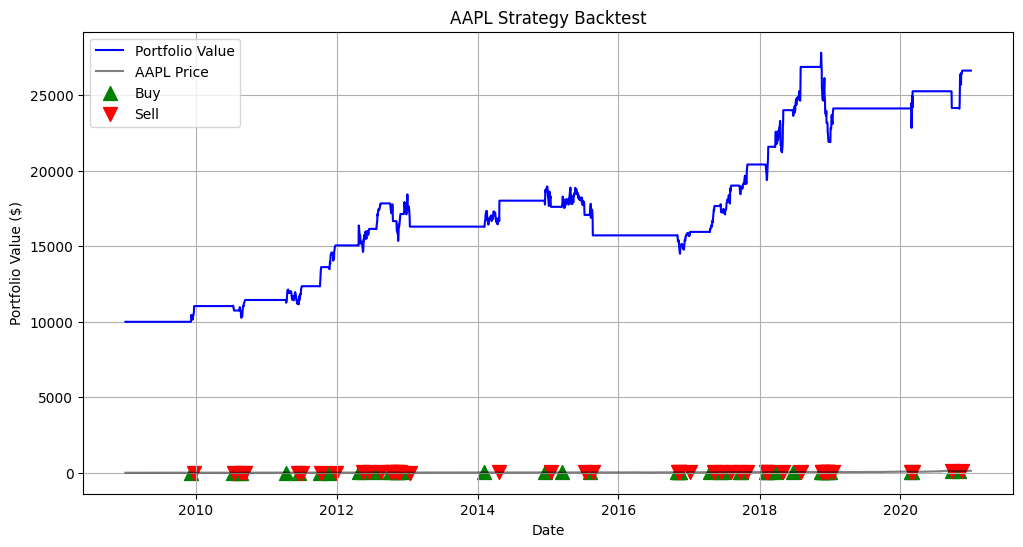

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical stock data
def get_data(stock_symbol, start, end):
    print(f"\nFetching data for {stock_symbol} from {start} to {end}...")
    data = yf.download(stock_symbol, start=start, end=end)
    data['100_MA'] = data['Close'].rolling(window=100).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()

    # RSI Calculation
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    data['BB_Upper'] = data['Close'].rolling(window=20).mean() + (data['Close'].rolling(window=20).std() * 2)
    data['BB_Lower'] = data['Close'].rolling(window=20).mean() - (data['Close'].rolling(window=20).std() * 2)
    
    print("Data download complete!\n")
    return data

# Backtesting strategy with Bollinger Bands and longer MAs
def backtest_strategy(data, initial_balance=10000, transaction_cost=0.001, stop_loss=0.02, take_profit=0.10, leverage=1):
    print("Backtesting the strategy...\n")
    balance = initial_balance
    shares = 0
    buy_price = 0
    history = []
    buy_signals = []
    sell_signals = []
    correct_predictions = 0
    total_predictions = 0
    max_portfolio_value = initial_balance

    for i in range(len(data)):
        # Buy signal: 100-day MA crosses above 200-day MA, RSI < 30 (oversold), avoid Bollinger Band extremes
        if data['100_MA'].iloc[i] > data['200_MA'].iloc[i] and shares == 0 and data['RSI'].iloc[i] < 30 and data['Close'].iloc[i] < data['BB_Upper'].iloc[i]:
            shares = (balance // data['Close'].iloc[i]) * leverage
            balance -= shares * data['Close'].iloc[i] * (1 + transaction_cost)
            buy_price = data['Close'].iloc[i]
            buy_signals.append((data.index[i], data['Close'].iloc[i]))
            total_predictions += 1
            
            # Check if the stock price increased within 5 days after the buy
            if i + 5 < len(data) and data['Close'].iloc[i + 5] > data['Close'].iloc[i]:
                correct_predictions += 1

        # Sell signal: 100-day MA crosses below 200-day MA, RSI > 70 (overbought), avoid Bollinger Band extremes
        elif data['100_MA'].iloc[i] < data['200_MA'].iloc[i] and shares > 0 and data['RSI'].iloc[i] > 70 and data['Close'].iloc[i] > data['BB_Lower'].iloc[i]:
            balance += shares * data['Close'].iloc[i] * (1 - transaction_cost)
            shares = 0
            sell_signals.append((data.index[i], data['Close'].iloc[i]))
            total_predictions += 1
            
            # Check if the stock price decreased within 5 days after the sell
            if i + 5 < len(data) and data['Close'].iloc[i + 5] < data['Close'].iloc[i]:
                correct_predictions += 1

        # Implement stop-loss to limit losses
        if shares > 0 and data['Close'].iloc[i] < buy_price * (1 - stop_loss):
            balance += shares * data['Close'].iloc[i] * (1 - transaction_cost)
            shares = 0
            sell_signals.append((data.index[i], data['Close'].iloc[i]))  # Log forced sell by stop-loss

        # Implement take-profit
        if shares > 0 and data['Close'].iloc[i] > buy_price * (1 + take_profit):
            balance += shares * data['Close'].iloc[i] * (1 - transaction_cost)
            shares = 0
            sell_signals.append((data.index[i], data['Close'].iloc[i]))  # Log take-profit sell

        # Track maximum portfolio value for drawdown
        portfolio_value = balance + shares * data['Close'].iloc[i]
        history.append(portfolio_value)
        max_portfolio_value = max(max_portfolio_value, portfolio_value)

    # Calculate final balance, total return, and accuracy
    final_balance = balance + shares * data['Close'].iloc[-1]
    total_return = (final_balance - initial_balance) / initial_balance * 100
    accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
    return final_balance, total_return, history, buy_signals, sell_signals, accuracy

# Helper functions for Sharpe Ratio, Max Drawdown, CAGR
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = np.array(returns) - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

def calculate_max_drawdown(history):
    peak = history[0]
    max_drawdown = 0
    for value in history:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

def calculate_cagr(initial_value, final_value, periods):
    if periods > 0 and initial_value > 0:
        try:
            return (final_value / initial_value) ** (1 / periods) - 1
        except (ValueError, ZeroDivisionError) as e:
            print(f"Error calculating CAGR: {e}")
            return float('nan')
    else:
        return float('nan')

def plot_performance(data, history, buy_signals, sell_signals, stock_symbol):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, history, label='Portfolio Value', color='blue')
    plt.plot(data.index, data['Close'], label=f'{stock_symbol} Price', color='black', alpha=0.5)
    
    if buy_signals:
        plt.scatter(*zip(*buy_signals), marker='^', color='green', label='Buy', s=100)
    if sell_signals:
        plt.scatter(*zip(*sell_signals), marker='v', color='red', label='Sell', s=100)
    
    plt.title(f'{stock_symbol} Strategy Backtest')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    stock_symbol = input("Enter the stock ticker symbol (e.g., AAPL): ").upper()
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")
    initial_balance = float(input("Enter the initial investment amount ($): "))
    data = get_data(stock_symbol, start=start_date, end=end_date)

    final_balance, total_return, history, buy_signals, sell_signals, accuracy = backtest_strategy(
        data, initial_balance, stop_loss=0.02, take_profit=0.10, leverage=1)

    daily_returns = np.diff(history) / history[:-1]
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(history)
    cagr = calculate_cagr(initial_balance, final_balance, periods=(len(data) / 252))

    # Output results
    print(f"\n=== Strategy Performance for {stock_symbol} ===")
    print(f"Initial Investment: ${initial_balance:,.2f}")
    print(f"Final Portfolio Value: ${final_balance:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f} (Higher is better; >1 is considered good)")
    print(f"Max Drawdown: {max_drawdown:.2f}% (Maximum loss from a peak to a trough)")
    print(f"CAGR: {cagr:.2f} (Annualized growth rate over the period)\n")
    print(f"Prediction Accuracy: {accuracy:.2f}% (Correct buy/sell predictions)\n")

    plot_performance(data, history, buy_signals, sell_signals, stock_symbol)

if __name__ == '__main__':
    main()
